El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.
A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

## Tabla de contenidos
* [Trabajo previo](#section1)
* [Preparación de datos](#section2)
    * [Limpieza de valores](#section21)
        * [Columna Price](#section211)
        * [Columna RegistrationYear](#section212)
        * [Columna RegistrationMonth](#section212) 
        * [Columna Power](#section213)
        * [Columna NumberOfPictures](#section214)
    * [Limpieza de nulos](#section22)
        * [Columna model](#section221)
        * [Columna NotRepaired](#section222)
        * [Columna VehicleType](#section223)
        * [Columna Gearbox](#section224)
        * [Columna FuelType](#section225)
    * [Partición y codificación](#section23)
* [Entrenamiento del modelo](#section3)
    * [Regresión lineal](#section31)
    * [Bosque aleatorio](#section32)
    * [LightGBM](#section33)
    * [CatBoost](#section34)
* [Análisis del modelo](#section4)

## Trabajo previo <a class="anchor" id="section1"></a>

In [153]:
# Cargamos algunas librerías útiles

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time

#from tqdm import tqdm
from tqdm.auto import tqdm

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import OneHotEncoder

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
#from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

In [154]:
# Cargamos nuestros datos

df = pd.read_csv("/datasets/car_data.csv")

Echemos una ojeada rápida antes de empezar a limpiar.

In [155]:
df.info()

df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Tenemos bastantes columnas para trabajar, revisaremos que tenemos en ellas y trabajaremos en acomodar los datos. Ahora veamos que sucede con los duplicados.

In [156]:
print(
    f"Tenemos {df[df.duplicated()].shape[0]} entradas duplicadas."
)

Tenemos 262 entradas duplicadas.


Removamos estas entradas.

In [157]:
# Removemos duplicados y reseteamos índices
df = df.drop_duplicates().reset_index(drop=True)

## Preparación de datos <a class="anchor" id="section2"></a>

Empecemos con mostrar un sample de nuestro dataset.

In [158]:
df.sample(n=5, random_state=2)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
338647,20/03/2016 16:45,4500,NaN,2017,manual,0,ducato,125000,1,gasoline,fiat,NaN,20/03/2016 00:00,0,74081,30/03/2016 08:15
229622,28/03/2016 17:52,900,wagon,1996,manual,170,3er,150000,10,petrol,bmw,no,28/03/2016 00:00,0,46244,06/04/2016 23:46
215278,05/03/2016 20:37,8100,sedan,1981,manual,122,3er,100000,8,petrol,bmw,no,05/03/2016 00:00,0,83129,05/04/2016 18:44
119335,28/03/2016 14:44,7950,sedan,2009,manual,122,golf,80000,1,petrol,volkswagen,no,28/03/2016 00:00,0,33619,31/03/2016 22:46
17070,01/04/2016 19:53,1200,small,2000,manual,58,twingo,150000,7,petrol,renault,no,01/04/2016 00:00,0,32547,05/04/2016 16:45


De nuestro print de info en la sección previa, podemos ver que tenemos 354369 entradas y varias columnas que tienen el tipo de dato mal: estas columnas son `DateCrawled`, `DateCreated`, `LastSeen`. Podríamos cambiarlas a _datetime64_, pero como crearemos modelos para entrenar, no nos serán útiles; las quitaremos.

In [159]:
# Hagamos el cambio
#df.DateCrawled = df.DateCrawled.astype("datetime64")

#df.DateCreated = df.DateCreated.astype("datetime64")

#df.LastSeen = df.LastSeen.astype("datetime64")

# Removamos columnas
df = df.drop(["DateCrawled", "DateCreated", "LastSeen"], axis=1)

# Mostremos

df.info()

df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354107 entries, 0 to 354106
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354107 non-null  int64 
 1   VehicleType        316623 non-null  object
 2   RegistrationYear   354107 non-null  int64 
 3   Gearbox            334277 non-null  object
 4   Power              354107 non-null  int64 
 5   Model              334406 non-null  object
 6   Mileage            354107 non-null  int64 
 7   RegistrationMonth  354107 non-null  int64 
 8   FuelType           321218 non-null  object
 9   Brand              354107 non-null  object
 10  NotRepaired        282962 non-null  object
 11  NumberOfPictures   354107 non-null  int64 
 12  PostalCode         354107 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 35.1+ MB


,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354107.000000,354107.000000,354107.000000,354107.000000,354107.000000,354107.0,354107.000000
mean,4416.433287,2004.235355,110.089651,128211.811684,5.714182,0.0,50507.145030
std,4514.338584,90.261168,189.914972,37906.590101,3.726682,0.0,25784.212094
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49406.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Todo se ve mejor, aunque todavía tenemos que revisar que sucede con algunos casos: nótese que existe alguna entrada con `Price` cero, lo cual nos hace ruido; al igual, no tiene sentido un valor de cero en `Power` o en `RegistrationMonth`. Por otro lado, parece que todos los valores de `NumberOfPictures` es cero y que hay autos registrados en hace mil años! Iremos limpiando estos valores y luego procederemos a trabajar con los nulos.

### Limpieza de valores <a class="anchor" id="section21"></a>
Partamos de la columna `Price`, veamos como se distribuyen los valores.

#### Columna `Price` <a class="anchor" id="section211"></a>

0        10770
500       5667
1500      5391
1000      4647
1200      4589
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: Price, Length: 3731, dtype: int64

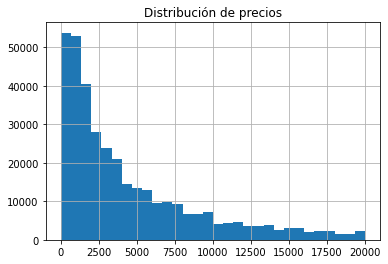

In [160]:
# Hagamos el value_counts
display(
    df.Price.value_counts()
)

# Un histograma para ver mejor
fig, axes = plt.subplots()

df.Price.hist(bins=30, ax=axes)

plt.title("Distribución de precios")
plt.show()

Viendo el histograma pareciera que todo está en órden, pero el value_counts muestra que tenemos muchos valores en cero, no nos hacen sentido y como Price es la métrica objetivo los eliminaremos.

In [161]:
df_cleaned = df[df.Price > 0]

df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343337 entries, 0 to 354106
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              343337 non-null  int64 
 1   VehicleType        309592 non-null  object
 2   RegistrationYear   343337 non-null  int64 
 3   Gearbox            325984 non-null  object
 4   Power              343337 non-null  int64 
 5   Model              325820 non-null  object
 6   Mileage            343337 non-null  int64 
 7   RegistrationMonth  343337 non-null  int64 
 8   FuelType           313882 non-null  object
 9   Brand              343337 non-null  object
 10  NotRepaired        277479 non-null  object
 11  NumberOfPictures   343337 non-null  int64 
 12  PostalCode         343337 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 36.7+ MB


Mejor, procedamos con lo mismo para `RegistrationYear`.

#### Columna `RegistrationYear` <a class="anchor" id="section212"></a>

Mostremos que tenemos.

2000    23058
1999    21970
2005    21509
2006    19654
2001    19637
        ...  
1949        1
2222        1
5300        1
8888        1
2290        1
Name: RegistrationYear, Length: 140, dtype: int64

Valores sorted
 [1000 1001 1039 1111 1234 1255 1300 1400 1500 1600 1602 1800 1910 1923
 1925 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1940
 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954
 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968
 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982
 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996
 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010
 2011 2012 2013 2014 2015 2016 2017 2018 2019 2066 2200 2222 2290 2500
 2800 2900 3000 3200 3700 3800 4000 4100 4500 4800 5000 5300 5555 5600
 5900 5911 6000 6500 7000 7100 7800 8000 8200 8500 8888 9000 9450 9999]


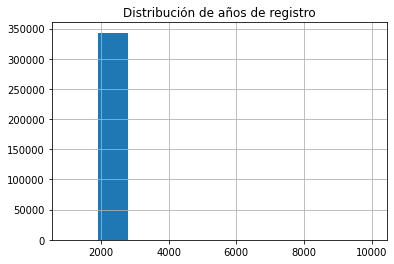

In [162]:
# Hagamos el value_counts
display(
    df_cleaned.RegistrationYear.value_counts()
)

# Mostremos años únicos
print(
    "Valores sorted\n",
    np.sort(
        df_cleaned.RegistrationYear.unique()
    )
)

# Un histograma para ver mejor
fig, axes = plt.subplots()

df_cleaned.RegistrationYear.hist(bins=10, ax=axes)

plt.title("Distribución de años de registro")
plt.show()

Viendo el histograma se ve todo bien, pero parece que tenemos algunos problemas con algunos años: nos quedaremos únicamente con los valores entre 1910 y 2019; los demás valores deben ser error de entrada.

In [163]:
# Limpiamos
df_cleaned = df_cleaned[df_cleaned.RegistrationYear >= 1910]
df_cleaned = df_cleaned[df_cleaned.RegistrationYear <= 2019]

display(
    df_cleaned.describe()
)
df_cleaned.info()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,343198.000000,343198.000000,343198.000000,343198.000000,343198.000000,343198.0,343198.000000
mean,4555.641225,2003.179130,110.977389,128386.179407,5.779285,0.0,50684.833117
std,4515.142480,7.372763,187.925533,37451.797973,3.697636,0.0,25745.527391
min,1.000000,1910.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1200.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30449.000000
50%,2890.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49525.000000
75%,6500.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71229.000000
max,20000.000000,2019.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 343198 entries, 0 to 354106
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              343198 non-null  int64 
 1   VehicleType        309592 non-null  object
 2   RegistrationYear   343198 non-null  int64 
 3   Gearbox            325957 non-null  object
 4   Power              343198 non-null  int64 
 5   Model              325734 non-null  object
 6   Mileage            343198 non-null  int64 
 7   RegistrationMonth  343198 non-null  int64 
 8   FuelType           313846 non-null  object
 9   Brand              343198 non-null  object
 10  NotRepaired        277458 non-null  object
 11  NumberOfPictures   343198 non-null  int64 
 12  PostalCode         343198 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 36.7+ MB


Mejor, procedamos con otras columnas.

#### Columna `RegistrationMonth` <a class="anchor" id="section213"></a>
Mostremos lo que sucede acá.

3     33794
0     32768
6     30804
4     28674
5     28511
7     26650
10    25586
12    23750
11    23738
9     23365
1     22643
8     22116
2     20799
Name: RegistrationMonth, dtype: int64

Valores sorted
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12]


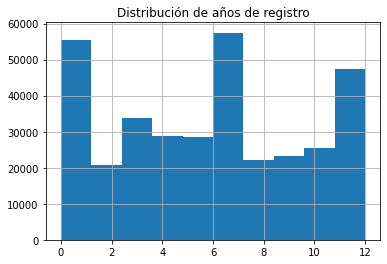

In [164]:
# Hagamos el value_counts
display(
    df_cleaned.RegistrationMonth.value_counts()
)

# Mostremos años únicos
print(
    "Valores sorted\n",
    np.sort(
        df_cleaned.RegistrationMonth.unique()
    )
)

# Un histograma para ver mejor
fig, axes = plt.subplots()

df_cleaned.RegistrationMonth.hist(bins=10, ax=axes)

plt.title("Distribución de años de registro")
plt.show()

Parece que tenemos bastantes entradas en donde el mes de registro es cero, lo cual no tiene sentido; también, por su parte, el tener el año debería ser suficiente nivel de granularidad: por lo anterior, mejor removeremos la columna de mes.

In [165]:
# Limpiamos
#df_cleaned = df_cleaned[df_cleaned.RegistrationMonth > 0 ]
df_cleaned = df_cleaned.drop("RegistrationMonth", axis=1)
#display(
#    df_cleaned.describe()
#)

df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343198 entries, 0 to 354106
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             343198 non-null  int64 
 1   VehicleType       309592 non-null  object
 2   RegistrationYear  343198 non-null  int64 
 3   Gearbox           325957 non-null  object
 4   Power             343198 non-null  int64 
 5   Model             325734 non-null  object
 6   Mileage           343198 non-null  int64 
 7   FuelType          313846 non-null  object
 8   Brand             343198 non-null  object
 9   NotRepaired       277458 non-null  object
 10  NumberOfPictures  343198 non-null  int64 
 11  PostalCode        343198 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 34.0+ MB


Veamos que sucede con la columna Power.

#### Columna `Power` <a class="anchor" id="section214"></a>

Mostremos.

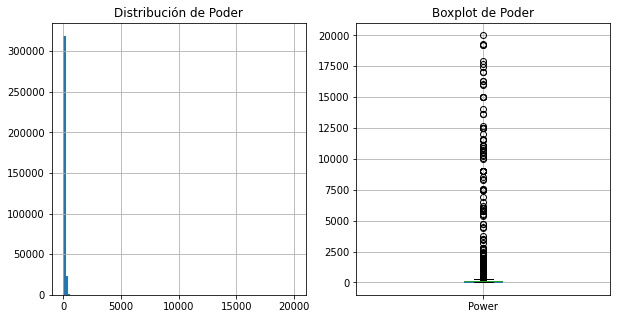

In [166]:
# Un histograma para ver mejor
fig, axes = plt.subplots(1,2, figsize=(10,5))

df_cleaned.Power.hist(bins=100, ax=axes[0])
df_cleaned.boxplot(column = ["Power"], ax=axes[1])

axes[0].set_title("Distribución de Poder")
axes[1].set_title("Boxplot de Poder")
plt.show()

La mitad de nuestros registros se hallan entre 75 y 143 CVs, por lo cual el histograma se ve concentrado cerca del cero. No tiene sentido el valor de cero, y en el otro lado del espectro, los valores mucho mayores no tienen sentido en el mundo real: solo un ejemplo, el FORD Mustang de hace unos años con 750 CVs era el más potente de su momento. Mostremos los 10 valores más altos para tener un mejor vistazo.

Ahora, mostremos los valores con los mayores en Power primero.

In [167]:
df_cleaned.sort_values("Power", ascending=False).head(n=10)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired,NumberOfPictures,PostalCode
219474,4300,coupe,1999,auto,20000,clk,150000,petrol,mercedes_benz,no,0,19406
298993,1500,wagon,1997,manual,19312,5er,150000,NaN,bmw,no,0,21129
114074,9999,sedan,2006,manual,19211,1er,125000,gasoline,bmw,NaN,0,45964
132446,2100,wagon,2001,manual,19208,5er,150000,NaN,bmw,yes,0,59556
63972,3250,sedan,2001,auto,17932,omega,150000,petrol,opel,NaN,0,86641
196439,6000,wagon,2004,auto,17700,5er,150000,gasoline,bmw,no,0,26316
150629,1700,wagon,1995,manual,17410,80,5000,petrol,audi,yes,0,23562
187247,1749,wagon,1989,manual,17019,3er,5000,petrol,bmw,NaN,0,89542
175347,10900,sedan,2007,auto,17011,a3,5000,gasoline,audi,NaN,0,12355
216886,11950,convertible,2008,manual,16312,a4,20000,petrol,audi,no,0,51647


Algunos de estos valores para `power` no tienen mucho sentido: una búsqueda rápida del modelo "clk" indica que tiene algo así como 150 CVs, no 20 mil. Procederemos a analizar que sucede con los valores dividiendolos en unos cuantos conjuntos y contando cuantos son.

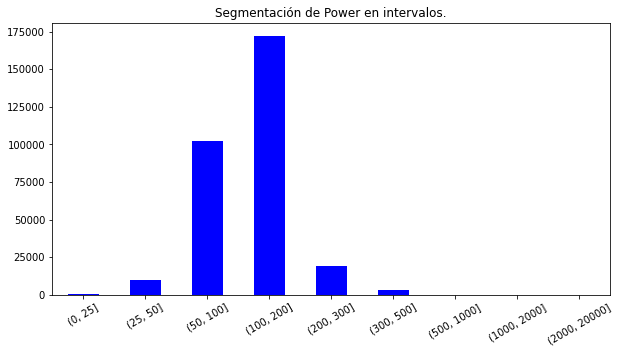

In [168]:
# Dividamos en bins y ploteemos.
#df_cleaned.query("Power <= 200000 & Power >= 2000").info()

bin_cut = pd.cut(df_cleaned.Power, bins= [0,25,50,100,200, 300, 500, 1000, 2000, 20000])

#out = pd.cut(s, bins=[0, 0.35, 0.7, 1], include_lowest=True)
ax = bin_cut.value_counts(sort=False).plot.bar(rot=30, color="b", figsize=(10,5))
#ax.set_xticklabels([c[1:-1].replace(","," to") for c in out.cat.categories])
plt.title("Segmentación de Power en intervalos.")
plt.show()

Los tres grupos más importantes, de 50 a 300 CVs son los que tienen la mayor cantidad de valores (y son valores realistas, por ejemplo hay modelos de Seat Ibiza con ~60 CVs). Nos quedaremos solo con esos para continuar nuestro estudio.

In [169]:
#df_cleaned = df_cleaned.drop("Power", axis=1)

df_cleaned = df_cleaned.query("Power <= 300 & Power >= 50").reset_index(drop=True)

df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297844 entries, 0 to 297843
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             297844 non-null  int64 
 1   VehicleType       277284 non-null  object
 2   RegistrationYear  297844 non-null  int64 
 3   Gearbox           292236 non-null  object
 4   Power             297844 non-null  int64 
 5   Model             286304 non-null  object
 6   Mileage           297844 non-null  int64 
 7   FuelType          278977 non-null  object
 8   Brand             297844 non-null  object
 9   NotRepaired       252699 non-null  object
 10  NumberOfPictures  297844 non-null  int64 
 11  PostalCode        297844 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 27.3+ MB


Podemos proceder a ver que sucede con la columna `NumberOfPictures`.

#### Columna `NumberOfPictures` <a class="anchor" id="section215"></a>
Veamos que tenemos.

In [170]:
df_cleaned.NumberOfPictures.value_counts()

0    297844
Name: NumberOfPictures, dtype: int64

Esta columna solo tiene ceros, no tiene sentido conservarla: la removemos.

In [171]:
df_cleaned = df_cleaned.drop("NumberOfPictures", axis=1)

Hemos hecho todo lo posible en estos campos, procedamos a la limpieza de valores nulos.

### Limpieza de nulos <a class="anchor" id="section22"></a>

#### Columna `model` <a class="anchor" id="section221"></a>

Empecemos con `model` ya que si no se sabe el modelo de un vehículo, realmente no se sabe de que tipo de automóvil se habla: veamos que tenemos ahí.

In [172]:
display(
    df_cleaned[df_cleaned.Model.isnull()].sample(n=5, random_state=1)
)

df_cleaned[df_cleaned.Model.isnull()].info()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired,PostalCode
148689,300,NaN,1995,manual,90,NaN,150000,petrol,volkswagen,NaN,4159
252609,1350,small,2001,manual,60,NaN,150000,NaN,volkswagen,no,45888
223764,800,small,1999,manual,50,NaN,150000,petrol,volkswagen,NaN,22549
17797,550,NaN,2017,manual,60,NaN,150000,petrol,sonstige_autos,NaN,96247
47572,3500,suv,1999,manual,128,NaN,150000,petrol,toyota,NaN,26789


<class 'pandas.core.frame.DataFrame'>
Int64Index: 11540 entries, 0 to 297830
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Price             11540 non-null  int64 
 1   VehicleType       8872 non-null   object
 2   RegistrationYear  11540 non-null  int64 
 3   Gearbox           10814 non-null  object
 4   Power             11540 non-null  int64 
 5   Model             0 non-null      object
 6   Mileage           11540 non-null  int64 
 7   FuelType          8361 non-null   object
 8   Brand             11540 non-null  object
 9   NotRepaired       7522 non-null   object
 10  PostalCode        11540 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 1.1+ MB


Reemplacemos los modelos nulos con una nueva categoría: `unknown`.

In [173]:
# Quitamos los models nulos y mostramos
#df_cleaned = df_cleaned.dropna(subset=["Model"])

# Imputamos
df_cleaned.Model = df_cleaned.Model.fillna("unknown")

# Vemos el resultado
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297844 entries, 0 to 297843
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             297844 non-null  int64 
 1   VehicleType       277284 non-null  object
 2   RegistrationYear  297844 non-null  int64 
 3   Gearbox           292236 non-null  object
 4   Power             297844 non-null  int64 
 5   Model             297844 non-null  object
 6   Mileage           297844 non-null  int64 
 7   FuelType          278977 non-null  object
 8   Brand             297844 non-null  object
 9   NotRepaired       252699 non-null  object
 10  PostalCode        297844 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 25.0+ MB


Se ve un poco mejor, ahora observemos que sucede con NotRepaired ya que es el que tiene más valores nulos:

#### Columna  `NotRepaired` <a class="anchor" id="section222"></a>
Primero un conteo de valores.

In [174]:
df_cleaned.NotRepaired.value_counts(dropna=False)

no     224020
NaN     45145
yes     28679
Name: NotRepaired, dtype: int64

Tenemos 42612 valores nulos, aquí podríamos intentar imputar en relación a otros valores como el año y modelo, pero otra opción es considerar una categoría nueva: _unknown_, que simplemente indica que no se sabía el valor.

In [175]:
# Imputamos
df_cleaned.NotRepaired = df_cleaned.NotRepaired.fillna("unknown")

# Vemos el resultado
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297844 entries, 0 to 297843
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             297844 non-null  int64 
 1   VehicleType       277284 non-null  object
 2   RegistrationYear  297844 non-null  int64 
 3   Gearbox           292236 non-null  object
 4   Power             297844 non-null  int64 
 5   Model             297844 non-null  object
 6   Mileage           297844 non-null  int64 
 7   FuelType          278977 non-null  object
 8   Brand             297844 non-null  object
 9   NotRepaired       297844 non-null  object
 10  PostalCode        297844 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 25.0+ MB


Para el resto de valores podemos imputar si existe alguna entrada similar.

#### Columna `VehicleType` <a class="anchor" id="section223"></a>
Definamos una función de imputación.

In [176]:
# Formula de imputación

def function_imputation(dataset, null_field):
    df_nulls = dataset[dataset[null_field].isnull()]
    df_not_nulls = dataset[~dataset[null_field].isnull()].drop_duplicates(subset=["Model", "Brand"])
    
    df_return = dataset.copy()
    
    for index, row in tqdm(df_nulls.iterrows()):
        try:
            match = df_not_nulls.query(
                "Model == @row['Model'] & Brand == @row['Brand']"
            ).iloc[0]
            
            #print(index, match.Model, "-", match.Brand)
            df_return.loc[index, null_field] = match[null_field]
        except:
            None
            
    return df_return

In [177]:
df_cleaned[~df_cleaned["VehicleType"].isnull()].drop_duplicates(subset=["Model", "Brand"])

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired,PostalCode
0,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes,66954
1,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown,90480
2,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,91074
3,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,60437
4,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,33775
...,...,...,...,...,...,...,...,...,...,...,...
93510,12500,suv,1975,manual,69,serie_3,70000,petrol,land_rover,no,24960
94239,4800,sedan,1974,manual,75,unknown,100000,NaN,lada,yes,96515
142645,1950,suv,2000,auto,177,freelander,150000,petrol,rover,no,83278
180350,1400,sedan,1987,manual,55,other,70000,petrol,trabant,unknown,15748


In [178]:
# Corramos la función
df_imput = function_imputation(df_cleaned, "VehicleType")

0it [00:00, ?it/s]

Veamos que tenemos tras hacer la imputación.

In [179]:
df_imput

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired,PostalCode
0,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes,66954
1,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown,90480
2,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,91074
3,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,60437
4,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,33775
...,...,...,...,...,...,...,...,...,...,...,...
297839,5250,sedan,2016,auto,150,159,150000,NaN,alfa_romeo,no,51371
297840,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes,96465
297841,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no,26135
297842,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no,87439


Se ve mejor, continúemos con `Gearbox`.

#### Columna `Gearbox` <a class="anchor" id="section224"></a>
Usemos la función de imputación anterior.

In [180]:
# Corramos la función
df_imput = function_imputation(df_imput, "Gearbox")

0it [00:00, ?it/s]

Veamos los resultados.

In [181]:
df_imput.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297844 entries, 0 to 297843
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             297844 non-null  int64 
 1   VehicleType       297844 non-null  object
 2   RegistrationYear  297844 non-null  int64 
 3   Gearbox           297844 non-null  object
 4   Power             297844 non-null  int64 
 5   Model             297844 non-null  object
 6   Mileage           297844 non-null  int64 
 7   FuelType          278977 non-null  object
 8   Brand             297844 non-null  object
 9   NotRepaired       297844 non-null  object
 10  PostalCode        297844 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 25.0+ MB


Perfecto, hagamos lo mismo con `FuelType`.

#### Columna `FuelType` <a class="anchor" id="section225"></a>
Hagamos lo mismo.

In [182]:
# Corramos la función
df_imput = function_imputation(df_imput, "FuelType")

0it [00:00, ?it/s]

Veamos detalles.

In [183]:
df_imput.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297844 entries, 0 to 297843
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             297844 non-null  int64 
 1   VehicleType       297844 non-null  object
 2   RegistrationYear  297844 non-null  int64 
 3   Gearbox           297844 non-null  object
 4   Power             297844 non-null  int64 
 5   Model             297844 non-null  object
 6   Mileage           297844 non-null  int64 
 7   FuelType          297844 non-null  object
 8   Brand             297844 non-null  object
 9   NotRepaired       297844 non-null  object
 10  PostalCode        297844 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 25.0+ MB


Solo reseteemos los índices para tener unos nuevos.

In [184]:
df_final = df_imput.reset_index(drop=True)

Aprovechemos a cambiar el nombre de las columnas a snake_case para evitar mayúsculas.

In [185]:
# Cambiemos los cases
df_final.columns = [
    "price", "vehicle_type",
    "registration_year", "gearbox", "power",
    "model", "mileage", "fuel_type", "brand", "not_repaired", "postal_code"
]

print(list(df_final.columns))

['price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'mileage', 'fuel_type', 'brand', 'not_repaired', 'postal_code']


Ya tenemos casi todo, solo nos falta dividir nuestros datos y codificarlos.

### Partición y codificación  <a class="anchor" id="section23"></a>

Trabajaremos con cuatro modelos diferentes: el de regresión lineal, el de bosque aleatorio, LightBoost y CatBoost (se omite XGBoost al ser opcional); para los primeros dos se requiere codificación de características por lo que haremos dos veces el conjunto de datos: uno codificado y uno no codificado. Usaremos una relación 30:70 para prueba y entrenamiento.

In [186]:
# Valores sin OHE
non_ohe_target = df_final.price
non_ohe_features = df_final.drop("price", axis=1)

# Partición de datos
feat_train_non_ohe, feat_test_non_ohe, target_train_non_ohe, target_test_non_ohe = train_test_split(
    non_ohe_features, non_ohe_target, test_size=0.3, random_state=1
)

# Aprovechamos a escalar los valores numéricos
scaler = StandardScaler()
scaler.fit(non_ohe_features[["registration_year", "mileage"]])

# Mostremos que tenemos

print(
    f"Non OHE | Features train: {feat_train_non_ohe.shape} \t | Features test: {feat_test_non_ohe.shape}",
    f"\nNon OHE | Targets test: {target_train_non_ohe.shape} \t | Targets test: {target_test_non_ohe.shape}"
)

Non OHE | Features train: (208490, 10) 	 | Features test: (89354, 10) 
Non OHE | Targets test: (208490,) 	 | Targets test: (89354,)


Estos son nuestros datos sin codificar, ahora hagamos el proceso para los datos codificados.

In [187]:
# Codificación
df_final_ohe = pd.get_dummies(df_final, drop_first=True)

# Valores con OHE
yes_ohe_target = df_final_ohe.price
yes_ohe_features = df_final_ohe.drop("price", axis=1)

# Dividimos
feat_train_yes_ohe, feat_test_yes_ohe, target_train_yes_ohe, target_test_yes_ohe = train_test_split(
    yes_ohe_features, yes_ohe_target, test_size=0.3, random_state=1
)

# Mostremos que tenemos

print(
    f"OHE | Features train: {feat_train_yes_ohe.shape} \t | Features test: {feat_test_yes_ohe.shape}",
    f"\nOHE | Targets test: {target_train_yes_ohe.shape} \t  \t | Targets test: {target_test_yes_ohe.shape}"
)

OHE | Features train: (208490, 308) 	 | Features test: (89354, 308) 
OHE | Targets test: (208490,) 	  	 | Targets test: (89354,)


## Entrenamiento del modelo  <a class="anchor" id="section3"></a>

Aquí haremos las pruebas de nuestros modelos; empezaremos con el test de cordura con el modelo de regresión lineal.

### Regresión lineal<a class="anchor" id="section31"></a>

In [188]:
# Inicializamos
model_linear = LinearRegression()

# Ajustamos con valores OHE
start_fit = time.time()
model_linear.fit(feat_train_yes_ohe, target_train_yes_ohe)
time_fit = time.time() - start_fit


# Predecimos
start_prediction = time.time()
predictions_linear = model_linear.predict(feat_test_yes_ohe)
time_prediction = time.time() - start_prediction

# Score
score_linear = mean_squared_error(target_test_yes_ohe, predictions_linear)**0.5

# Resultados
resultados_lr = ["Regresión lineal", time_fit, time_prediction, score_linear]

In [189]:
# Veamos que tenemos
pd.DataFrame(
    [resultados_lr], columns = ["Modelo", "Tiempo de Ajuste", "Tiempo de Predicción", "RMSE"]
)

,Modelo,Tiempo de Ajuste,Tiempo de Predicción,RMSE
0,Regresión lineal,16.157108,0.201374,2634.797212


Funciona bien, podemos continuar con nuestros modelos.

### Bosque aleatorio<a class="anchor" id="section32"></a>
Correremos una búsqueda del modelo de bosque aleatorio para la profundidad máxima y el número de estimadores.

In [190]:
# Definimos el modelo
model_forest = RandomForestRegressor(random_state=1)

# Los parametros a buscar
parameters = {
    "max_depth": [10, 15, 20],
    "n_estimators": [10, 30, 50]
}

# Buscamos los parametros
grid_forest = GridSearchCV(
    estimator=model_forest, param_grid=parameters, scoring='neg_mean_squared_error', verbose=10
)

# Ajustamos
grid_forest.fit(feat_train_yes_ohe, target_train_yes_ohe)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START max_depth=10, n_estimators=10...............................
[CV 1/5; 1/9] END .............max_depth=10, n_estimators=10; total time=  17.3s
[CV 2/5; 1/9] START max_depth=10, n_estimators=10...............................
[CV 2/5; 1/9] END .............max_depth=10, n_estimators=10; total time=  17.3s
[CV 3/5; 1/9] START max_depth=10, n_estimators=10...............................
[CV 3/5; 1/9] END .............max_depth=10, n_estimators=10; total time=  17.9s
[CV 4/5; 1/9] START max_depth=10, n_estimators=10...............................
[CV 4/5; 1/9] END .............max_depth=10, n_estimators=10; total time=  17.3s
[CV 5/5; 1/9] START max_depth=10, n_estimators=10...............................
[CV 5/5; 1/9] END .............max_depth=10, n_estimators=10; total time=  17.3s
[CV 1/5; 2/9] START max_depth=10, n_estimators=30...............................
[CV 1/5; 2/9] END .............max_depth=10, n_es

GridSearchCV(estimator=RandomForestRegressor(random_state=1),
             param_grid={'max_depth': [10, 15, 20],
                         'n_estimators': [10, 30, 50]},
             scoring='neg_mean_squared_error', verbose=10)

Veamos resultados.

In [191]:
grid_forest.best_params_

{'max_depth': 20, 'n_estimators': 50}

Procedamos a entrenar con 50 estimadores y 20 de profundidad.

In [192]:
# Declaramos y ajustamos
model_random_forest = RandomForestRegressor(n_estimators = 50, max_depth=20, random_state=1)

start_fit = time.time()
model_random_forest.fit(feat_train_yes_ohe, target_train_yes_ohe)
time_fit = time.time() - start_fit

# Predecimos
start_prediction = time.time()
prediction_random_forest = model_random_forest.predict(feat_test_yes_ohe)
time_prediction = time.time() - start_prediction

# Score
score_forest = mean_squared_error(target_test_yes_ohe, prediction_random_forest)**0.5

# Resultados
resultados_forest = ["Bosque aleatorio", time_fit, time_prediction, score_forest]

In [193]:
# Veamos que tenemos
pd.DataFrame(
    [resultados_lr, resultados_forest], columns = ["Modelo", "Tiempo de Ajuste", "Tiempo de Predicción", "RMSE"]
)

,Modelo,Tiempo de Ajuste,Tiempo de Predicción,RMSE
0,Regresión lineal,16.157108,0.201374,2634.797212
1,Bosque aleatorio,178.563302,1.571493,1589.453325


### LightGBM <a class="anchor" id="section33"></a>

Empecemos con la paquetería LightGBM la cual necesita que nuestras variables categóricas se hallen con el tipo categoría. Hagamos el cambio.

In [194]:
# Es más legible definirlas aquí
list_cats = ["vehicle_type", "gearbox", "model", "fuel_type", "brand", "not_repaired"]

# Convertimos tanto entrenamiento como prueba
feat_train_non_ohe[list_cats] = feat_train_non_ohe[list_cats].astype('category')
feat_test_non_ohe[list_cats] = feat_test_non_ohe[list_cats].astype('category')

# Veamos que todo esta bien
feat_train_non_ohe.info()

feat_test_non_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 208490 entries, 275898 to 128037
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   vehicle_type       208490 non-null  category
 1   registration_year  208490 non-null  int64   
 2   gearbox            208490 non-null  category
 3   power              208490 non-null  int64   
 4   model              208490 non-null  category
 5   mileage            208490 non-null  int64   
 6   fuel_type          208490 non-null  category
 7   brand              208490 non-null  category
 8   not_repaired       208490 non-null  category
 9   postal_code        208490 non-null  int64   
dtypes: category(6), int64(4)
memory usage: 9.4 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 89354 entries, 238491 to 158472
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   vehicle_type   

Vayamos al entrenamiento del modelo.

In [195]:
# Definimos el modelo
model_lightgbm = LGBMRegressor()

# Los parametros a buscar
parameters = {
    "learning_rate":[0.05, 0.005],
    "num_leaves": [7, 15, 31],
    "max_depth": [5, 10, 15],
    "n_estimators": [10, 20, 30]
}

# Buscamos los parametros
grid_lightgbm = GridSearchCV(
    estimator=model_lightgbm, param_grid=parameters, scoring='neg_mean_squared_error'
)

# Ajustamos
grid_lightgbm.fit(feat_train_non_ohe, target_train_non_ohe)

GridSearchCV(estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.05, 0.005],
                         'max_depth': [5, 10, 15], 'n_estimators': [10, 20, 30],
                         'num_leaves': [7, 15, 31]},
             scoring='neg_mean_squared_error')

Veamos los mejores parámetros.

In [196]:
grid_lightgbm.best_params_

{'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 30, 'num_leaves': 31}

Ahora entrenemos nuestro modelo con estos parámetros y predigamos.

In [197]:
# Entrenamiento
start_fit = time.time()
model_lightgbm_final = LGBMRegressor(
    learning_rate=0.05, max_depth = 10, n_estimators=30, num_leaves=31, random_state=1
)
model_lightgbm_final.fit(feat_train_non_ohe, target_train_non_ohe)
time_fit = time.time() - start_fit

# Predecimos
start_prediction = time.time()
predictions_lightgbm = model_lightgbm_final.predict(feat_test_non_ohe)
time_prediction = time.time() - start_prediction

# Score
score_lightgbm = mean_squared_error(target_test_non_ohe, predictions_lightgbm)**0.5

# Resultados
resultados_lightgbm = ["LightGBM", time_fit, time_prediction, score_lightgbm]

In [198]:
# Veamos que tenemos
pd.DataFrame(
    [resultados_lr, resultados_forest, resultados_lightgbm],
    columns = ["Modelo", "Tiempo de Ajuste", "Tiempo de Predicción", "RMSE"]
)

,Modelo,Tiempo de Ajuste,Tiempo de Predicción,RMSE
0,Regresión lineal,16.157108,0.201374,2634.797212
1,Bosque aleatorio,178.563302,1.571493,1589.453325
2,LightGBM,1.789781,0.291243,2147.516105


### CatBoost <a class="anchor" id="section34"></a>
Procedamos con CatBoost en donde tampoco necesitamos usar codificación. Primero obtengamos los mejores parámetros.

In [199]:
# Instanciamos el modelo
model_catboost = CatBoostRegressor(logging_level="Silent")

# Los parametros a buscar
parameters = {
    "learning_rate":[0.05, 0.005],
    "depth": [5, 10, 15],
    "iterations" : [5, 10],
    "random_seed": [1]
}

# Buscamos los parametros
grid_catboost = GridSearchCV(
    estimator=model_catboost, param_grid=parameters, scoring='neg_mean_squared_error'
)

# Ajustamos
grid_catboost.fit(feat_train_non_ohe, target_train_non_ohe, cat_features = list_cats)

GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x7f6ed65644f0>,
             param_grid={'depth': [5, 10, 15], 'iterations': [5, 10],
                         'learning_rate': [0.05, 0.005], 'random_seed': [1]},
             scoring='neg_mean_squared_error')

Veamos los mejores parámetros.

In [200]:
grid_catboost.best_params_

{'depth': 15, 'iterations': 10, 'learning_rate': 0.05, 'random_seed': 1}

Ahora procedamos a usar estos parámetros para entrenar y hacer las pruebas.

In [201]:
# Entrenamiento
start_fit = time.time()
model_catboost_final = CatBoostRegressor(
    learning_rate=0.05, depth = 15, iterations = 10, random_seed=1
)
model_catboost_final.fit(feat_train_non_ohe, target_train_non_ohe, cat_features = list_cats)
time_fit = time.time() - start_fit

# Predecimos
start_prediction = time.time()
predictions_catboost = model_catboost_final.predict(feat_test_non_ohe)
time_prediction = time.time() - start_prediction

# Score
score_catboost = mean_squared_error(target_test_non_ohe, predictions_catboost)**0.5

# Resultados
resultados_catboost = ["CatBoost", time_fit, time_prediction, score_catboost]

0:	learn: 4367.9993118	total: 1.16s	remaining: 10.4s
1:	learn: 4208.3987118	total: 2.31s	remaining: 9.22s
2:	learn: 4060.0069717	total: 3.43s	remaining: 8s
3:	learn: 3921.1214273	total: 4.58s	remaining: 6.87s
4:	learn: 3789.0399390	total: 5.7s	remaining: 5.7s
5:	learn: 3665.1297755	total: 6.83s	remaining: 4.55s
6:	learn: 3544.6678576	total: 7.97s	remaining: 3.42s
7:	learn: 3432.4700375	total: 9.2s	remaining: 2.3s
8:	learn: 3328.9958352	total: 10.4s	remaining: 1.15s
9:	learn: 3232.6175038	total: 11.6s	remaining: 0us


In [202]:
# Veamos que tenemos
resultados = pd.DataFrame(
    [resultados_lr, resultados_forest, resultados_lightgbm, resultados_catboost],
    columns = ["Modelo", "Tiempo de Ajuste", "Tiempo de Predicción", "RMSE"]
)

display(
    resultados
)

,Modelo,Tiempo de Ajuste,Tiempo de Predicción,RMSE
0,Regresión lineal,16.157108,0.201374,2634.797212
1,Bosque aleatorio,178.563302,1.571493,1589.453325
2,LightGBM,1.789781,0.291243,2147.516105
3,CatBoost,12.064708,0.081067,3234.560596


## Análisis del modelo <a class="anchor" id="section4"></a>
Ahora que contamos con toda nuestra información podemos hacer gráficos para entender como es el rendimiento de nuestros modelos en tiempo y métricas RMSE.

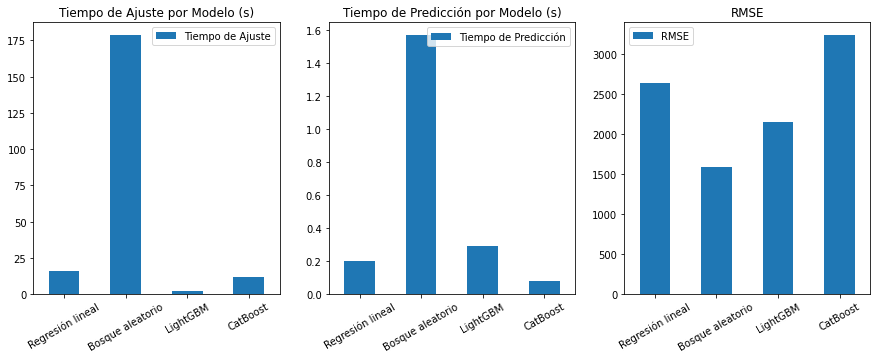

In [203]:
fig, axes = plt.subplots(1,3, figsize=(15,5))

resultados.plot(x="Modelo", y="Tiempo de Ajuste", kind="bar", rot=30, ax=axes[0])
resultados.plot(x="Modelo", y="Tiempo de Predicción", kind="bar", rot=30, ax=axes[1])
resultados.plot(x="Modelo", y="RMSE", kind="bar", rot=30, ax=axes[2])

axes[0].set_title("Tiempo de Ajuste por Modelo (s)")
axes[1].set_title("Tiempo de Predicción por Modelo (s)")
axes[2].set_title("RMSE")

axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[2].set_xlabel("")

plt.show()

De la figura podemos ver que claramente el modelo que mejor tiempo de ajuste fue el de LightGBM en contra del claro perdedor de Bosque aleatorio: la proporción es de más de 80:1. Podemos decir que usar LightGBM es mucho más rápido y puede ser usado como una primer inspección (no tiene los mejores resultados).

En el caso de la predicción igual el bosque aleatorio sufre de un tiempo mucho mayor que el resto, pero el órden ya no es el mismo: aquí CatBoost es el ganador.

En el caso de la métrica RMSE, el claro ganador es el Bosque Aleatorio: tiene el valor más bajo pero el tiempo de cómputo es muy alto: para un momento en que se necesite una mucha mayor predicción es útil, pero si la diferencia no es tan sensible podría preferirse usar un modelo menos preciso pero más rápido de ejecutar.